# Aprendiendo Fashion-MNIST con PyTorch

## Refs.

* https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

* https://github.com/zalandoresearch/fashion-mnist

* https://github.com/pranay414/Fashion-MNIST-Pytorch/blob/master/fashion_mnist.ipynb

## **Ejercicio 1)** Importando librerías

**0)** De ser necesario, **instale PyTorch** escribiendo

    !pip3 install torch torchvision torchaudio torchviz

**1)** Importe las librerías estandard de Python: `os`, `datetime`, `collections` y `pickle`.

**2)** Importe las siguientes librerías third party de Python: `matplotlib.pyplot`, `numpy`, `scipy`, `sklearn`, `pandas`, `dill` y `json`.

**3)** Importe las librerias necesarias de **PyTorch**: `torch` y `torchvision`.

**4)** Importe la librería: `google.colab`.

In [18]:
# 1.0)
!pip3 install torch torchvision torchaudio torchviz

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: C:\Users\usuario\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [19]:
# 1.1)
import os
import pickle
import datetime
from collections import defaultdict

In [20]:
# 1.2)
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import scipy as sp
import scipy.linalg as linalg
import sklearn as skl
import pandas as pd
#import dill
import json

In [21]:
# 1.3)
import torch
import torch.optim as optim
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import datasets
from torchvision import transforms
from torchvision.io import read_image
from torchvision.transforms import ToTensor, Lambda, Compose
#from torchviz import make_dot

In [22]:
# 1.4)
import google.colab
from google.colab import files

ModuleNotFoundError: No module named 'google'

## **Ejercicio 2)**

Bajando y Jugando con el dataset **Fashion-MNIST**.

**1)** Baje y transforme (i.e. normalize los valores de los pixeles) los conjuntos de entrenamiento y testeo de FashionMNIST.

**2)** Explore algunos ejemplos de estos conjuntos. Que formato poseen?

**3)** Visitando la página web de FashionMNIST, cree un diccionario de Python `Dict()` asociando cada categoría a un nombre adecuado de la misma.

**4)** Grafique un mosaico de 3x3 imagenes de FashionMNIST, cada una titulada con su respectiva clasificación

In [23]:
# 2.1)
# Define a transform to normalize the data
transform = transforms.Compose([
                                transforms.ToTensor()
                                ,transforms.Normalize((0.5,), (0.5,))
                                #,transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

# Download and load the training data
train_set = datasets.FashionMNIST('MNIST_data/', download = True, train = True,  transform = transform)
valid_set = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)

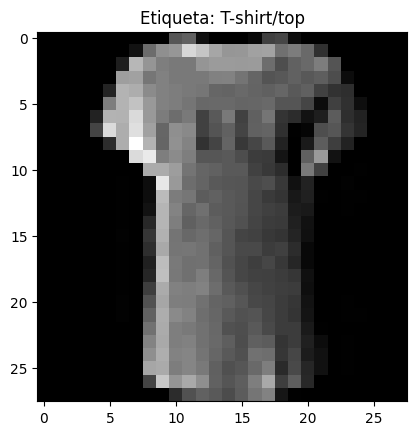

Forma del tensor de la imagen: torch.Size([1, 28, 28])


In [24]:
#2.2 
i = 600
img, label = train_set[i]

#2.3
label_dict = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

# Como tiene forma [1, 28, 28], quitamos la dimensión del canal

plt.imshow(img.squeeze(), cmap='gray')
plt.title(f"Etiqueta: {label_dict[label]}")
plt.show()
print(f"Forma del tensor de la imagen: {img.shape}")
#img tiene shape [C, H, W]. Si C = 1 sólo existe img[0], 
# para acceder a un píxel: img[0, y, x].
#cuando es rgb es como si tuvieras 3 matrices, una por canal, 
# cada una de ellas indica la cantidad de cada color en cada píxel.
#como aca hay un solo canal, ya que es escala de grises, hay una dimension innecesaria.
#por eso se usa squeeze, para eliminar dimensiones de tamaño 1.

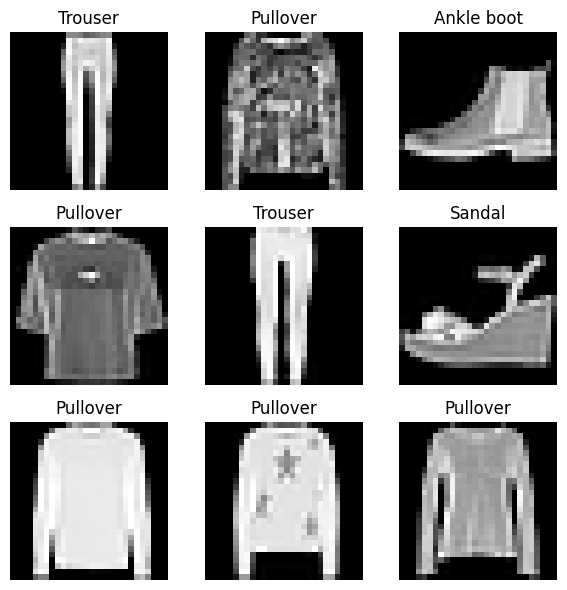

In [25]:

#2.4
#mosaico 3x3 de imagenes random
fig, axes = plt.subplots(3, 3, figsize=(6, 6))
for ax in axes.flatten():
    i = np.random.randint(len(train_set))
    img, label = train_set[i]
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(f"{label_dict[label]}")
    ax.axis('off')
plt.tight_layout()
plt.show()


## Ejercicio 3)

Creando un `DataLoader` para alimentar el modelo con batchs (lotes) de entrenamiento.

**1)** Cree los `DataLoader`s para cada conjunto. Defínalos con un `batch_size` de 100 y con el flag `shuffle` seteado a `True`.

**2)** Use uno de los `DataLoader`s creados anteriormente para explorar algunos elementos del conjunto.

Notar que, el iterador devuelve el batch en un par `(image,label)`.

El objeto `images` es un tensor de dimensiones `(100,1,28,28)`.
El 100 es el tamaño del batch.
El 1 porque hay un solo canal (en este caso, un canal de escala de grises, pero podría haber varios, p. ej. uno por cada color de {Red, Green Blue} en caso que fuesen imagenes a color).
Luego, 28 y 28 porque cada imagen del dataset es de 28 x 28 píxeles.

El objeto `labels` es un tensor de dimensiones `(100,)`.
La $i$-ésima entrada `labels[i]` de `labels` es un número en $\{0,1,...,9\}$ indicando la categoría a la que pertenece la $i$-ésima imagen en el batch, guardada en `images[i]`.

In [26]:
# 3.1)
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 100, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size = 100, shuffle = True)

#Un datalloader empaqueta el dataset en batches, dejando una estructura iterable
# es como una estructura que tiene en cada "slot"(que representaria un batch) un tensor con imagenes y otro con labels
#osea que por ejemplo en la primer posicion de la estructura tendrias 100 imagenes y 100 labels del primer batch.

 num_samples : 60000
 num_batches : 600
Forma del batch de imágenes: torch.Size([100, 1, 28, 28])
Forma del batch de etiquetas: torch.Size([100])


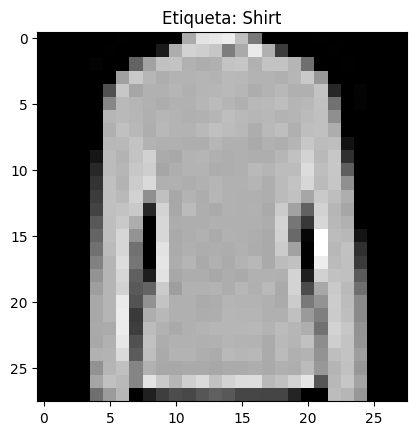

In [27]:
print(f" num_samples : {len(train_loader.dataset)}")
print(f" num_batches : {len(train_loader)}")
dataiter = iter(train_loader)
#si shuffle esta en false da siempre lo mismo, porque siempre creo el iterador 
# de nuevo. Si no, como shuffle los crea distinto cada vez, da distinto.
# next(dataiter) # si pongo esto antes, entonces muestro el segundo
images, labels = next(dataiter)
print(f"Forma del batch de imágenes: {images.shape}")
print(f"Forma del batch de etiquetas: {labels.shape}")

#img example
img = images[0]  # Agregar dimensión de batch
label = label_dict[labels[0].item()]

plt.imshow(img.squeeze(), cmap='gray')
plt.title(f"Etiqueta: {label}")
plt.show()

## Ejercicio 4)

Defina una red neuronal de 4 capas, una de entrada, dos ocultas de $n_1=128$ y $n_2=64$ neuronas, respectivamente, y una de salida de 10 neuronas.

En las capas intermedias utilice neuronas tipo ReLU y agregueles un *dropout* de p=0.2.
En la capa de salida no utilice funciones de activación ni dropout.

Las capas sucesivas tienen que estar totalmente conectadas entre si.

In [28]:
# 4)
class NeuralNetwork(nn.Module):
    def __init__(self,n1,n2,p=0.2):
        super(NeuralNetwork,self).__init__()
        #capa0
        self.flatten = nn.Flatten() 

        #capa 1
        self.fc1 = nn.Linear(28*28,n1)  
        self.relu = nn.ReLU() #modulo relu1
        self.dropout = nn.Dropout(p) #modulo dropout1

        #capa2
        self.fc2 = nn.Linear(n1,n2)      #capa 2
        #self.relu2 = nn.ReLU()           #modulo relu2 (se reutilizan las del 1 asi q las comento)
        #self.dropout2 = nn.Dropout(p)    #modulo dropout2

        #capa3
        self.fc3 = nn.Linear(n2,10)     #capa 3
    
    def forward(self,x):
        #capa0
        x = self.flatten(x)
        #capa1
        x = self.fc1(x)             
        x = self.relu(x)            #modulo relu1
        x = self.dropout(x)         #modulo dropout1
        #capa2
        x = self.fc2(x)             
        x = self.relu(x)            #modulo relu2
        x = self.dropout(x)         #modulo dropout2
        #capa3
        x = self.fc3(x)             
        return x

mi_red = NeuralNetwork(128,64,p=0.2)
mi_red(img).shape

torch.Size([1, 10])

## Ejercicio 5)

Entrenamos el modelo

**1)** Implemente, en una función, un loop de entrenamiento que recorra los batchs (lotes).

**2)** Implemente, en una función, un loop de validación que recorra los batchs.

**3)** Inicialize dos `DataLoader`s llamados `train_loader` y `valid_loader` a partir del `train_set` (conjunto de entranmiento) y del `valid_set` (conjunto de validación) de Fashion-MNIST, respectivamente, y que usen batchs de 100 ejemplos.

**4)** Cree una función de pérdida usando la **Cross Entropy Loss**.

**IMPORTANTE:** Notar que la **Cross Entropy Loss** aplica automáticamente una `log_softmax`.

**5)** Cree un optimizador que utilice el método de **Stochastic Gradient Descent** con un learning rate igual a $10^{-3}$.

**6)** Cree una instancia del modelo.

**7)** Especifique en que dispositivo (`device`) va a trabajar: en una **CPU** o en una **GPU**.

**8)** Implemente un loop de entrenamiento y validación que trabaje con el `train_loader` y el `valid_loader`, respectivamente, usando un numero arbitrario de épocas.
Este loop debe guardar en cuatro listas los valores de los promedios del **Cross Entropy Loss** y las fracciones de clasificaciones correctas o **precisión** (accuracy) sobre el conjunto de **entrenamiento** y el de **validación**, respectivamente.

**IMPORTANTE:** No olvide copiar los batchs al dispositivo de trabajo.

**9)** Entrene y valide el modelo.

**10)** Use las listas del inciso anterior para graficar en función de las épocas la **Cross Entropy Loss** de **entrenamiento** y de **validación**.
Realize un gráfico análogo pero con la **precisión**.
Discuta y comente, cual es el número óptimo de épocas de entrenamiento?

**11)** Repita los experimentos variando hiperparámetros. Por ejemplo:

- El learning-rate.
- El optimizador (ej. puede usar ADAM).
- El valor de dropout.
- El número de neuronas en las capas intermedias.
- El número de épocas de entrenamiento.
- El tamaño de los lotes.

Discuta los resultados.

In [58]:
# 5.1)
def train_loop(dataloader,model,loss_fn,optimizer):
    model.train()
    num_samples = len(dataloader.dataset)
    num_batches = len(dataloader)
    sum_loss = 0
    sum_correct = 0
    sum_samples = 0
    for batch, (X,y) in enumerate(dataloader): 
        #enumerate devuelve una lista de tuplas (indice, valor), entonces al hacer
        # for batch, (X,y) desestructura la tupla en indice(batch) y valor(X(imagenes), y(etiquetas))

        # Copiamos las salidas y entradas al dispositivo de trabajo
        X, y = X.to(device), y.to(device)

        # Forward pass
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Statistics
        batch_size = len(X)
        # calculamos la perdida promedio del batch y lo agregamos a una suma correspondiente
        sum_loss += loss.item() * batch_size # loss = suma de perdidas en el batch / batch_size => loss.item() * batch_size = suma de perdidas en el batch

        # calculamos la cantidad de predicciones correctas en el batch y lo agregamos a una suma correspondiente
        sum_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        # actualizamos la cantidad de muestras procesadas
        sum_samples += batch_size

        if batch % (num_batches / 10) == 0: # evaluamos en el 10% de los batches, para no saturar
            avrg_loss = sum_loss / sum_samples
            precision = sum_correct / sum_samples
            print(f"  Batch {batch:>5d}/{num_batches:>5d} - avrg_Loss: {avrg_loss:>7f}  processed_samples: {100*sum_samples/num_samples:>5f}%") #5d ?
        
    assert num_samples == sum_samples, "Error en el conteo de muestras procesadas"
    avrg_loss = sum_loss / sum_samples
    precision = sum_correct / sum_samples

    return avrg_loss, precision

In [59]:
#5.2)
def valid_loop(dataloader,model,loss_fn):
    model.eval()
    num_samples = len(dataloader.dataset)
    num_batches = len(dataloader)
    sum_loss = 0
    sum_correct = 0
    sum_samples = 0
    with torch.no_grad(): # es un context manager que desactiva el cálculo del gradiente momentáneamente, 
        #para ahorrar memoria y mejorar el rendimiento durante la evaluación del modelo.

        for X,y in dataloader: #iteramos sobre los batches del dataloader, esto es posible ya que si bien dataloader no es una lista,
            # implementa el protocolo iterable de python, por lo que se puede usar en un for, y en cada iteracion genera un batch nuevo

            # Copiamos las salidas y entradas al dispositivo de trabajo
            X, y = X.to(device), y.to(device)
            batch_size = len(X)
            sum_samples += batch_size

            pred = model(X)
            loss = loss_fn(pred, y)

            sum_loss += loss.item() * batch_size
            sum_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    assert num_samples == sum_samples, "Error en el conteo de muestras procesadas"
    avrg_loss = sum_loss / sum_samples
    precision = sum_correct / sum_samples
    print(f"@eval_loop_avg_loss={avrg_loss:>8f}  precision={100*precision:0.1f}%")

    return avrg_loss, precision

In [31]:
# 5.3)
batch_size = 100
train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size = batch_size, shuffle = True)

In [32]:
#5.4)
#Creamos una instancia de una funcion de perdida, en este caso Cross Entropy Loss
loss_fn = nn.CrossEntropyLoss()

In [33]:
#5.6)
#valores segun ej4
n1 = 128
n2 = 64 
p = 0.2
model = NeuralNetwork(n1,n2,p)

#5.5)
#definimos el optimizador, en este caso SGD
learning_rate = 1e-3
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
#optimizer = optim.Adam(model.parameters(), lr=learning_rate,eps=1e-08,weight_decay=0,amsgrad=False)

In [62]:
#5.7)
#definimos el dispositivo de trabajo, una cpu o una gpu si esta disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#pasamos el modelo al dispositivo
model = model.to(device)
print(torch.cuda.is_available())


False


In [60]:
#5.8) y 5.9)
num_epochs = 30
list_train_avg_loss_incorrecta = []
list_train_avg_loss = []
list_valid_avg_loss = []
list_train_precisiom_incorrecta = []
list_train_precision = []
list_valid_precision = []
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}:\n-------------------------------")
    train_avg_loss_incorrecta, train_precision_incorrecta = train_loop(train_loader, model, loss_fn, optimizer)
    train_avg_loss, train_precision = valid_loop(train_loader, model, loss_fn)
    valid_avg_loss, valid_precision = valid_loop(valid_loader, model, loss_fn)

    list_train_avg_loss_incorrecta.append(train_avg_loss_incorrecta)
    list_train_precisiom_incorrecta.append(train_precision_incorrecta)

    list_train_avg_loss.append(train_avg_loss)
    list_valid_avg_loss.append(valid_avg_loss)

    list_train_precision.append(train_precision)
    list_valid_precision.append(valid_precision)

print("Training complete.")

Epoch 1/30:
-------------------------------
  Batch     0/  600 - avrg_Loss: 2.304383  processed_samples: 0.166667%
  Batch    60/  600 - avrg_Loss: 2.289954  processed_samples: 10.166667%
  Batch   120/  600 - avrg_Loss: 2.283245  processed_samples: 20.166667%
  Batch   180/  600 - avrg_Loss: 2.275261  processed_samples: 30.166667%
  Batch   240/  600 - avrg_Loss: 2.267302  processed_samples: 40.166667%
  Batch   300/  600 - avrg_Loss: 2.259245  processed_samples: 50.166667%
  Batch   360/  600 - avrg_Loss: 2.251037  processed_samples: 60.166667%
  Batch   420/  600 - avrg_Loss: 2.242515  processed_samples: 70.166667%
  Batch   480/  600 - avrg_Loss: 2.233692  processed_samples: 80.166667%
  Batch   540/  600 - avrg_Loss: 2.224562  processed_samples: 90.166667%
@eval_loop_avg_loss=2.104499  precision=47.3%
@eval_loop_avg_loss=2.105811  precision=46.9%
Epoch 2/30:
-------------------------------
  Batch     0/  600 - avrg_Loss: 2.123509  processed_samples: 0.166667%
  Batch    60/  600

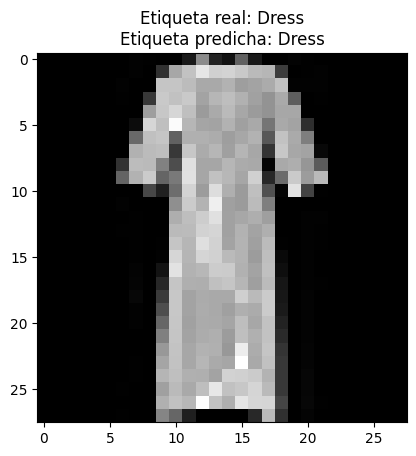

torch.Size([1, 28, 28])

In [ ]:
# probando la red entrenada con un ejemplito
dataiter = iter(valid_loader)
images, labels = next(dataiter)
numero_img = 16
img = images[numero_img]  # Agregar dimensión de batch
label = labels[numero_img].item()
# Pasar la imagen por el modelo
with torch.no_grad():
    img = img.to(device)
    output = model(img.unsqueeze(0))  # Agregar dimensión de batch
    predicted_label = output.argmax(1).item()

#imagen:
plt.imshow(img.cpu().squeeze(), cmap='gray')
plt.title(f"Etiqueta real: {label_dict[label]}\nEtiqueta predicha: {label_dict[predicted_label]}")
plt.show()

img.shape
    

Tensor de entrada listo. Dimensiones: torch.Size([1, 28, 28])


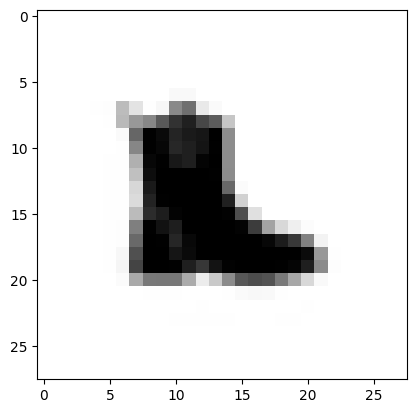

In [93]:
#ahora saque una imagen random que creo gemini de una bota y voy  a ver que dice el modelo que es
from PIL import Image
# 1. Definir la ruta de la imagen (ajusta esto si estás en Colab/local)
# Nota: Si la imagen está guardada en tu entorno de trabajo
image_path = "bota_28x28.png" 

# 2. Definir las transformaciones necesarias
# Tienes que replicar las transformaciones que usaste en tu dataset de entrenamiento
transform = transforms.Compose([
    # Asegura que esté en escala de grises (1 canal)
    transforms.Grayscale(num_output_channels=1), 
    # Asegura el tamaño (aunque ya sea 28x28)
    transforms.Resize((28, 28)), 
    # Convierte la imagen a tensor (el valor va de [0, 255] a [0.0, 1.0])
    transforms.ToTensor(), 
])

# 3. Cargar y transformar
try:
    img = Image.open(image_path)
    input_tensor = transform(img)

    print(f"Tensor de entrada listo. Dimensiones: {input_tensor.shape}")

except FileNotFoundError:
    print(f"Error: No se encontró el archivo en {image_path}. Asegúrate de guardar la imagen primero.")


plt.imshow(input_tensor.squeeze(), cmap='gray')
plt.show()


In [95]:
model.to(device)
# Mueve el tensor de entrada al dispositivo
input_tensor = input_tensor.to(device)

# Poner el modelo en modo de evaluación
model.eval() 

# 5. Obtener la predicción
with torch.no_grad():
    output = model(input_tensor.unsqueeze(0))
    #predicted_label = output.argmax(1).item()

# 6. Interpretar la salida
# La salida es un tensor de 10 valores (los logits).
# Aplicamos softmax para obtener probabilidades y argmax para la clase con mayor probabilidad.
probabilities = torch.nn.functional.softmax(output, dim=1)
predicted_class = probabilities.argmax(1).item()
confidence = probabilities.max(1)[0].item()

print("\n--- Resultados de la Predicción ---")
print(f"Probabilidades (logits): {output.squeeze().tolist()}")
print(f"Clase Predicha (Índice): {predicted_class}")
print(f"Confianza: {confidence * 100:.2f}%")


print(f"Predicción: {label_dict[predicted_class]}")

#print(f"predicted_label = {label_dict[predicted_label]}")


#Logits : salidas directas, sin procesar, de la capa final de la red neuronal (que tiene 10 salidas).Son valores que representan el puntaje que el modelo calcula para cada label.
#softmax transforma logits a probabilidades
# la confianza es el porcentaje que da la salida mas alta, si el porcentaje es bajo es porque las otras salidas tambien tienen "una proporcion significativa de probabilidad de ser correctas"
#cuando eso pasa tiene sentido que sea menos confiable
#asi que la confiabilidad es basicamente el porcentaje del valor que dio mas alto


--- Resultados de la Predicción ---
Probabilidades (logits): [-0.08142711967229843, -0.08191318809986115, -0.054625168442726135, -0.21207505464553833, -0.15941309928894043, -0.18328900635242462, 0.12738773226737976, -0.13684889674186707, 0.0379333570599556, 0.20257465541362762]
Clase Predicha (Índice): 9
Confianza: 12.82%
Predicción: Ankle boot
